In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda


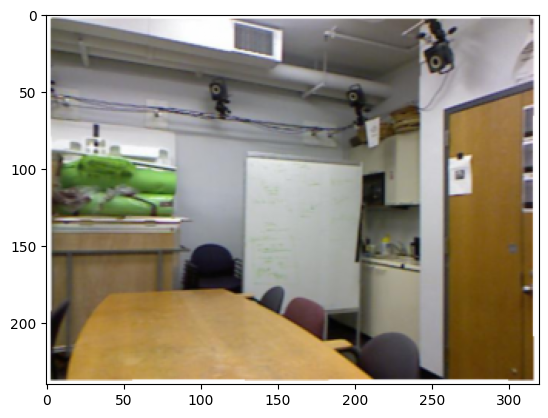

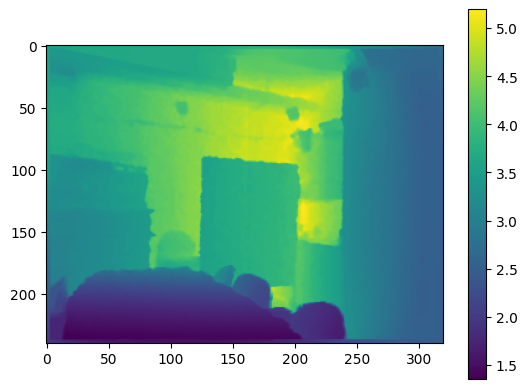

In [3]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
gt_aif, gt_dpt = utils.load_single_sample(sample='0005', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

# max_kernel_size = utils.kernel_size_heuristic(width, height)
# print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011977933..1.0000046].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0058796634..1.0011694].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015380319..1.0014019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0034650548..1.0004005].


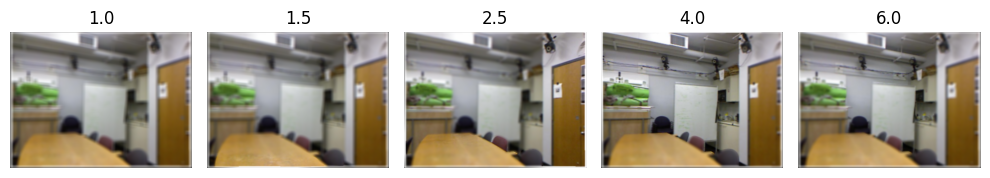

In [4]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



(240, 320, 5)


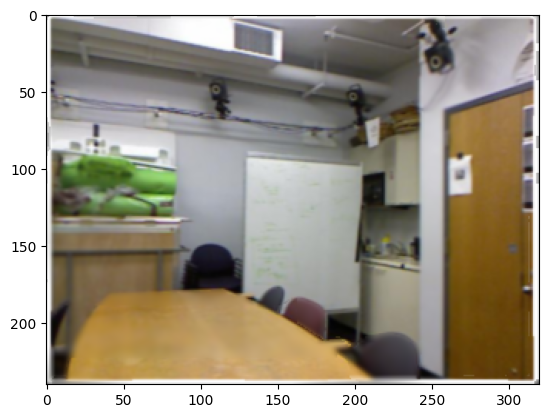

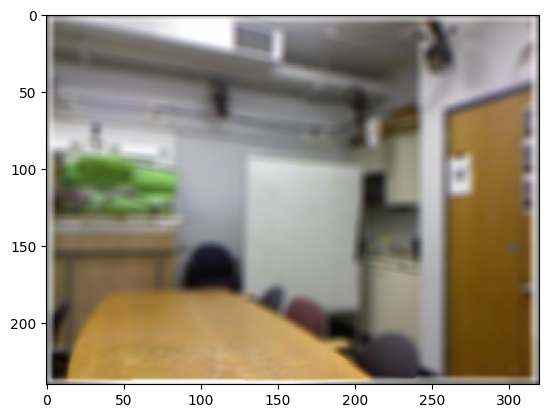

In [5]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=40,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init,
                                                 finite_differences=False, num_Z=100, ls_maxiter=50, ls_maxiter_multiplier=1.05,#1.075, 
                                                 use_CUDA=True)


Created experiment folder: experiments/coord-descent_2025-06-20_01-31-45
Images in range [0-255]
Iteration 0 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   7970.332490  41771.953411      25
  green   8200.834104  39527.322949      25
   blue   8449.426963  36245.029133      25

AIF result range: [ -61.036902272637235 , 312.6571096475236 ]
Loss: 175.4969940185547 , TV: 2449997.4587064562
Loss after clipping: 176.60435485839844 , TV: 2390183.5469902186



Grid search         : 100%|███████████████████| 100/100 [00:19<00:00,  5.19it/s]


Loss: 44.15193082165702

Golden-section search...
...searching for 100 % convergence
...done
Loss: 43.98591139226913 , TV: 174279.09888684476

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 52


--------------------------

Iteration 1 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   2420.109115  42707.732508      52
  green   2557.886503  40617.688575      52
   blue   2680.242716  37559.985364      52

AIF result range: [ -461.30829545469 , 527.5625284710941 ]
Loss: 16.999488700934517 , TV: 11069611.938838068
Loss after clipping: 23.7773373308434 , TV: 10238641.153832115



Grid search         : 100%|███████████████████| 100/100 [00:13<00:00,  7.61it/s]


Loss: 14.25938656970652

Golden-section search...
...searching for 100 % convergence


In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]